In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler, TomekLinks
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import BertModel, BertTokenizer
from typing import Callable, List, Optional, Tuple
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv('/home/jason/toxic_model/train_preprocessed.csv')
print(df.shape)

(159571, 10)


In [3]:
sequences = df["comment_text"].values
targets = df['identity_hate'].values
print(sequences.shape)
print(targets.shape)

(159571,)
(159571,)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    sequences, targets, test_size=0.2, random_state=42
)

In [5]:
class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        bert_tokenizer,
        bert_model,
        max_length: int = 60,
        embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.tokenizer = bert_tokenizer
        self.model = bert_model
        self.model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        # Tokenize the text with the provided tokenizer
        tokenized_text = self.tokenizer.encode_plus(
            text, add_special_tokens=True, max_length=self.max_length
        )["input_ids"]

        # Create an attention mask telling BERT to use all words
        attention_mask = [1] * len(tokenized_text)

        # bert takes in a batch so we need to unsqueeze the rows
        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        """No fitting necessary so we just return ourselves"""
        return self

In [6]:
bert_dataset = "bert-base-uncased"

def tfidf():
    return Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer())])

def bert():
    tokenizer = BertTokenizer.from_pretrained(bert_dataset)
    bert_model = BertModel.from_pretrained(bert_dataset)
    return BertTransformer(tokenizer, bert_model)


In [28]:
weights = compute_class_weight('balanced', np.unique(targets), targets)
weights

array([ 0.50444154, 56.78683274])

In [33]:
smote = SMOTE(random_state=12)
borderline_smote = BorderlineSMOTE(sampling_strategy=0.5,k_neighbors=5,random_state=42, kind="borderline-1")
random_undersampler = RandomUnderSampler(sampling_strategy=1, random_state=42)
# adasyn = ADASYN(sampling_strategy=0.5,random_state=42)

model = Pipeline(
    [
        ("vect", CountVectorizer()),
        ("tfidf", TfidfTransformer()),
#         ("adasyn", adasyn),
        ("smote", borderline_smote),
#         ("under-sampling", random_undersampler),
#         ("tomek", TomekLinks(n_jobs=8)),
        ("mnb", XGBClassifier(weights=weights)),
    ]
)

In [34]:
model.fit(X_train, y_train)

/home/jason/.local/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:34:51] WARNING: ../src/learner.cc:573: 
Parameters: { "weights" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:34:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('smote',
                 BorderlineSMOTE(random_state=42, sampling_strategy=0.5)),
                ('mnb',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                           

In [35]:
THRESH = 0.5
pred = model.predict(X_test)
y_pred = (pred > THRESH).astype(int)

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     31621
         1.0       0.52      0.45      0.48       294

    accuracy                           0.99     31915
   macro avg       0.76      0.72      0.74     31915
weighted avg       0.99      0.99      0.99     31915

[[31497   124]
 [  162   132]]


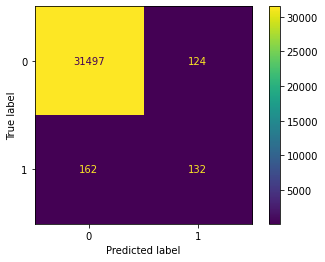

In [36]:
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels=[0, 1])
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
disp.plot()
plt.show()